In [5]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import spacy
import contractions
from time import time
import re
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1',header=None)
test_original = pd.read_csv('titles_yahoo_financial_616.csv',encoding='UTF-8')

In [4]:
data.columns = ['Sentiment','News Titles']

In [32]:
t = time()

def breif_cleanning(text):
    
    #undo contraction
    text=contractions.fix(text)
    
    # remove <br />
    text=text.replace('<br />','')    
    
    # remove punctuations
    text=re.sub("[^A-Za-z]+", ' ', text)
    
    return text.lower()
    

data['cleaned_headlines']=data['News Titles'].apply(breif_cleanning)  
test_original['cleaned_headlines']=test_original['News Titles'].apply(breif_cleanning)  

# disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
# Lemmatizes and removes stopwords
# doc needs to be a spacy Doc object

def cleaning(doc):    
    
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    return ' '.join(txt)

#txt= [cleaning(doc) for doc in nlp.pipe(data['cleaned_reviews'], batch_size=2500, n_process=4)]
txt= [cleaning(doc) for doc in nlp.pipe(data['cleaned_headlines'], n_process=1)]
data['cleaned_headlines'] = pd.DataFrame(txt)
txt= [cleaning(doc) for doc in nlp.pipe(test_original['cleaned_headlines'], n_process=1)]
test_original['cleaned_headlines'] = pd.DataFrame(txt)
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.12 mins


In [33]:
data = data.dropna(subset=['cleaned_headlines'])
test_original = test_original.dropna(subset=['cleaned_headlines'])

In [47]:
vectorizer = CountVectorizer()
X_all = vectorizer.fit_transform(data['cleaned_headlines'])
X_test_all = vectorizer.transform(test_original['cleaned_headlines'])

In [48]:
data_pos_neg = data[(data['Sentiment'] == 'positive')|(data['Sentiment'] == 'negative')]
data_pos_neu = data[(data['Sentiment'] == 'positive')|(data['Sentiment'] == 'neutral')]
data_neg_neu = data[(data['Sentiment'] == 'neutral')|(data['Sentiment'] == 'negative')]

## Positive VS Negative

In [49]:
X = vectorizer.transform(data_pos_neg['cleaned_headlines'])
y = (data_pos_neg['Sentiment']=='positive').astype(int)

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=2)
log_model = LogisticRegression()
results = log_model.fit(X=X_train, y=y_train)

#using the model to predict testing data
y_pred = results.predict(X_test)
score_lr = metrics.accuracy_score(y_test, y_pred)
print(score_lr)

0.8191056910569106


In [53]:
data['flag_pos_neg_lr'] = results.predict(X_all)
data['flag_pos_neg_lr'] = data['flag_pos_neg_lr'].apply(lambda x: 'positive' if x == 1 else 'negative')
test_original['flag_pos_neg_lr'] = results.predict(X_test_all)
test_original['flag_pos_neg_lr'] = test_original['flag_pos_neg_lr'].apply(lambda x: 'positive' if x == 1 else 'negative')

In [54]:
#get n words associated with largest coefficeints
n=5
#argsort sort the list, - to sort from max to min (get the top n words with largest weight)
max_index=(-results.coef_[0]).argsort()[:n]
print(max_index)
print(vectorizer.get_feature_names_out()[max_index])
# (get the top n words with smallest weight)
min_index=(results.coef_[0]).argsort()[:n]
print(vectorizer.get_feature_names_out()[min_index])

[5544 2955 2612 2932 4960]
['rise' 'increase' 'grow' 'improve' 'positive']
['decrease' 'fall' 'drop' 'decline' 'low']


In [55]:
nb_classifier=MultinomialNB()
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)
score_nb = metrics.accuracy_score(y_test, pred)
print(score_nb)

0.7987804878048781


In [56]:
data['flag_pos_neg_nb'] = nb_classifier.predict(X_all)
data['flag_pos_neg_nb'] = data['flag_pos_neg_nb'].apply(lambda x: 'positive' if x == 1 else 'negative')
test_original['flag_pos_neg_nb'] = nb_classifier.predict(X_test_all)
test_original['flag_pos_neg_nb'] = test_original['flag_pos_neg_nb'].apply(lambda x: 'positive' if x == 1 else 'negative')

In [57]:
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')  
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
score_svm=metrics.accuracy_score(y_test, predictions_SVM)
print(score_svm)

0.8089430894308943


In [58]:
data['flag_pos_neg_svm'] = SVM.predict(X_all)
data['flag_pos_neg_svm'] = data['flag_pos_neg_svm'].apply(lambda x: 'positive' if x == 1 else 'negative')
test_original['flag_pos_neg_svm'] = SVM.predict(X_test_all)
test_original['flag_pos_neg_svm'] = test_original['flag_pos_neg_svm'].apply(lambda x: 'positive' if x == 1 else 'negative')

## Positive VS Neutral

In [60]:
X = vectorizer.transform(data_pos_neu['cleaned_headlines'])
y = (data_pos_neu['Sentiment']=='positive').astype(int)

In [61]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=2)
log_model = LogisticRegression()
results = log_model.fit(X=X_train, y=y_train)

#using the model to predict testing data
y_pred = results.predict(X_test)
score_lr = metrics.accuracy_score(y_test, y_pred)
print(score_lr)

0.8152686145146089


In [62]:
data['flag_pos_neu_lr'] = results.predict(X_all)
data['flag_pos_neu_lr'] = data['flag_pos_neu_lr'].apply(lambda x: 'positive' if x == 1 else 'neutral')
test_original['flag_pos_neu_lr'] = results.predict(X_test_all)
test_original['flag_pos_neu_lr'] = test_original['flag_pos_neu_lr'].apply(lambda x: 'positive' if x == 1 else 'neutral')

In [63]:
#get n words associated with largest coefficeints
n=5
#argsort sort the list, - to sort from max to min (get the top n words with largest weight)
max_index=(-results.coef_[0]).argsort()[:n]
print(max_index)
print(vectorizer.get_feature_names_out()[max_index])
# (get the top n words with smallest weight)
min_index=(results.coef_[0]).argsort()[:n]
print(vectorizer.get_feature_names_out()[min_index])

[5544 2955 2932  482 7292]
['rise' 'increase' 'improve' 'award' 'win']
['include' 'electricity' 'disclose' 'range' 'approximately']


In [64]:
nb_classifier=MultinomialNB()
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)
score_nb = metrics.accuracy_score(y_test, pred)
print(score_nb)

0.7483506126295947


In [65]:
data['flag_pos_neu_nb'] = nb_classifier.predict(X_all)
data['flag_pos_neu_nb'] = data['flag_pos_neu_nb'].apply(lambda x: 'positive' if x == 1 else 'neutral')
test_original['flag_pos_neu_nb'] = nb_classifier.predict(X_test_all)
test_original['flag_pos_neu_nb'] = test_original['flag_pos_neu_nb'].apply(lambda x: 'positive' if x == 1 else 'neutral')

In [66]:
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')  
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
score_svm=metrics.accuracy_score(y_test, predictions_SVM)
print(score_svm)

0.7728557964184731


In [67]:
data['flag_pos_neu_svm'] = SVM.predict(X_all)
data['flag_pos_neu_svm'] = data['flag_pos_neu_svm'].apply(lambda x: 'positive' if x == 1 else 'neutral')
test_original['flag_pos_neu_svm'] = SVM.predict(X_test_all)
test_original['flag_pos_neu_svm'] = test_original['flag_pos_neu_svm'].apply(lambda x: 'positive' if x == 1 else 'neutral')

## Negative VS Neutral

In [68]:
X = vectorizer.transform(data_neg_neu['cleaned_headlines'])
y = (data_neg_neu['Sentiment']=='negative').astype(int)

In [69]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=2)
log_model = LogisticRegression()
results = log_model.fit(X=X_train, y=y_train)

#using the model to predict testing data
y_pred = results.predict(X_test)
score_lr = metrics.accuracy_score(y_test, y_pred)
print(score_lr)

0.9035591274397244


In [70]:
data['flag_neg_neu_lr'] = results.predict(X_all)
data['flag_neg_neu_lr'] = data['flag_neg_neu_lr'].apply(lambda x: 'negative' if x == 1 else 'neutral')
test_original['flag_neg_neu_lr'] = results.predict(X_test_all)
test_original['flag_neg_neu_lr'] = test_original['flag_neg_neu_lr'].apply(lambda x: 'negative' if x == 1 else 'neutral')

In [71]:
#get n words associated with largest coefficeints
n=5
#argsort sort the list, - to sort from max to min (get the top n words with largest weight)
max_index=(-results.coef_[0]).argsort()[:n]
print(max_index)
print(vectorizer.get_feature_names_out()[max_index])
# (get the top n words with smallest weight)
min_index=(results.coef_[0]).argsort()[:n]
print(vectorizer.get_feature_names_out()[min_index])

[1530 2172 4269 1789 3729]
['decrease' 'fall' 'negative' 'drop' 'loss']
['include' 'value' 'new' 'headquarter' 'approximately']


In [72]:
nb_classifier=MultinomialNB()
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)
score_nb = metrics.accuracy_score(y_test, pred)
print(score_nb)

0.8760045924225028


In [73]:
data['flag_neg_neu_nb'] = nb_classifier.predict(X_all)
data['flag_neg_neu_nb'] = data['flag_neg_neu_nb'].apply(lambda x: 'negative' if x == 1 else 'neutral')
test_original['flag_neg_neu_nb'] = nb_classifier.predict(X_test_all)
test_original['flag_neg_neu_nb'] = test_original['flag_neg_neu_nb'].apply(lambda x: 'negative' if x == 1 else 'neutral')

In [74]:
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')  
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
score_svm=metrics.accuracy_score(y_test, predictions_SVM)
print(score_svm)

0.894374282433984


In [75]:
data['flag_neg_neu_svm'] = SVM.predict(X_all)
data['flag_neg_neu_svm'] = data['flag_neg_neu_svm'].apply(lambda x: 'negative' if x == 1 else 'neutral')
test_original['flag_neg_neu_svm'] = SVM.predict(X_test_all)
test_original['flag_neg_neu_svm'] = test_original['flag_neg_neu_svm'].apply(lambda x: 'negative' if x == 1 else 'neutral')

## Performance

In [79]:
data['flag_lr'] = data[['flag_pos_neg_lr', 'flag_pos_neu_lr', 'flag_neg_neu_lr']].mode(axis=1)[0]
data['flag_nb'] = data[['flag_pos_neg_nb', 'flag_pos_neu_nb', 'flag_neg_neu_nb']].mode(axis=1)[0]
data['flag_svm'] = data[['flag_pos_neg_svm', 'flag_pos_neu_svm', 'flag_neg_neu_svm']].mode(axis=1)[0]

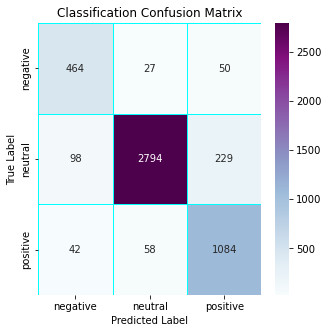

In [86]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(data['flag_lr'], data['Sentiment'])
f, ax = plt.subplots(figsize=(5, 5))

# 绘制混淆矩阵的热图
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu",
            xticklabels=['negative', 'neutral', 'positive'],  # 设置 X 轴标签
            yticklabels=['negative', 'neutral', 'positive'])  # 设置 Y 轴标签

# 设置图形的标题和轴标签
plt.title('Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 显示图形
plt.show()

In [94]:
# 假设 data 是您的 DataFrame，并且已经包含了 'flag_lr' 和 'Sentiment' 列
# 计算准确率
accuracy = metrics.accuracy_score(data['flag_lr'], data['Sentiment'])
print("Accuracy:", accuracy)

Accuracy: 0.8959966983078828


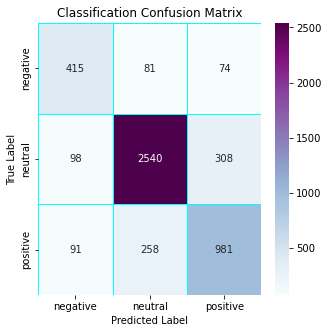

In [92]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(data['flag_nb'], data['Sentiment'])
f, ax = plt.subplots(figsize=(5, 5))

# 绘制混淆矩阵的热图
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu",
            xticklabels=['negative', 'neutral', 'positive'],  # 设置 X 轴标签
            yticklabels=['negative', 'neutral', 'positive'])  # 设置 Y 轴标签

# 设置图形的标题和轴标签
plt.title('Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 显示图形
plt.show()

In [95]:
accuracy = metrics.accuracy_score(data['flag_nb'], data['Sentiment'])
print("Accuracy:", accuracy)

Accuracy: 0.8122162608336773


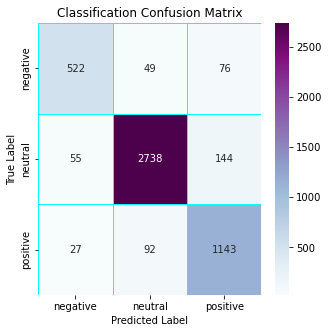

In [93]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(data['flag_svm'], data['Sentiment'])
f, ax = plt.subplots(figsize=(5, 5))

# 绘制混淆矩阵的热图
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu",
            xticklabels=['negative', 'neutral', 'positive'],  # 设置 X 轴标签
            yticklabels=['negative', 'neutral', 'positive'])  # 设置 Y 轴标签

# 设置图形的标题和轴标签
plt.title('Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 显示图形
plt.show()

In [96]:
accuracy = metrics.accuracy_score(data['flag_svm'], data['Sentiment'])
print("Accuracy:", accuracy)

Accuracy: 0.9085843995047462


In [87]:
test_original['flag_lr'] = test_original[['flag_pos_neg_lr', 'flag_pos_neu_lr', 'flag_neg_neu_lr']].mode(axis=1)[0]
test_original['flag_nb'] = test_original[['flag_pos_neg_nb', 'flag_pos_neu_nb', 'flag_neg_neu_nb']].mode(axis=1)[0]
test_original['flag_svm'] = test_original[['flag_pos_neg_svm', 'flag_pos_neu_svm', 'flag_neg_neu_svm']].mode(axis=1)[0]

In [91]:
test_original['flag_svm'].value_counts()

neutral     398
positive    124
negative     94
Name: flag_svm, dtype: int64

In [97]:
test_original[['News Titles','flag_svm']].to_csv('SVM_output.csv', index=False)